<a href="https://colab.research.google.com/github/NiallJeffrey/post-Newtonian/blob/master/jax_integrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as np
from jax import jit
from jax.experimental.ode import odeint
import scipy.integrate as osp_integrate

from jax.config import config
config.update("jax_enable_x64", True)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print('(GPU is often slower)')

cpu
(GPU is often slower)


In [2]:
@jit
def relative_a_component(r, Gm):
    return -Gm*r* (np.linalg.norm(r)**(-3))

@jit
def relative_dynamics(y,t,Gm):
    r, v = y.reshape((2,3))
    dydt = np.concatenate([v, relative_a_component(r, Gm)])
    return dydt.reshape(-1)


@jit
def relative_dynamics_flipped_inputs(t, y, Gm):
    r, v = y.reshape((2,3))
    dydt = np.concatenate([v, relative_a_component(r, Gm)])
    return dydt.reshape(-1)

In [3]:
y0 = np.array([-1, 1, 0, .1, 0.5, 0.])
Gm_val = 1
tsteps = np.linspace(0, 200, 2000)

In [5]:
%time scipy_result = osp_integrate.odeint(relative_dynamics, y0, tsteps, (Gm_val,), rtol=1e-11)
%time scipy_result_ivp = osp_integrate.solve_ivp(relative_dynamics_flipped_inputs, np.array([tsteps[0],tsteps[-1]]), y0, t_eval=tsteps, args=(Gm_val,), rtol=1e-11).y.T
%time jax_result = odeint(relative_dynamics, y0, tsteps, np.array([Gm_val]), rtol=1e-11)

CPU times: user 1.57 s, sys: 1.02 s, total: 2.59 s
Wall time: 1.76 s
CPU times: user 2.14 s, sys: 610 ms, total: 2.75 s
Wall time: 2.14 s
CPU times: user 671 ms, sys: 1.12 ms, total: 672 ms
Wall time: 686 ms


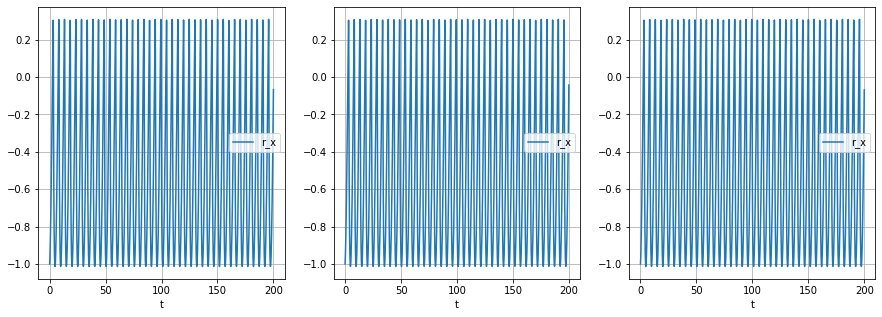

In [6]:
_ = plt.figure(figsize=(15,5)), plt.subplot(1,3,1)
_ = plt.plot(tsteps, scipy_result[:, 0], label='r_x')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.subplot(1,3,2), plt.plot(tsteps, scipy_result_ivp[:, 0], label='r_x')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.subplot(1,3,3), plt.plot(tsteps, jax_result[:, 0], label='r_x')
# _ = plt.plot(tsteps, jax_result[:, 1], label='r_y')
# _ = plt.plot(tsteps, np.sqrt(jax_result[:, 0]**2.+jax_result[:, 1]**2.), label='|r|')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()

In [9]:
%time scipy_result_faster = osp_integrate.odeint(relative_dynamics, np.array(y0), np.array(tsteps), (Gm_val,), rtol=1.4e-8)
%time scipy_ivp_faster = osp_integrate.solve_ivp(relative_dynamics_flipped_inputs, np.array([tsteps[0],tsteps[-1]]), y0, t_eval=tsteps, args=(Gm_val,), rtol=1.4e-8).y.T
%time jax_result_faster = odeint(relative_dynamics, np.array(y0), np.array(tsteps), np.array([Gm_val]), rtol=1.4e-8)

print('\nMSE error relative to jax low-tolerance')
print('scipy:', np.mean(np.square(jax_result[:, 0] - scipy_result_faster[:, 0])))
print('scipy ivp:', np.mean(np.square(jax_result[:, 0] - scipy_ivp_faster[:, 0])))
print('jax:', np.mean(np.square(jax_result[:, 0] - jax_result_faster[:, 0])))

print('\nMSE error relative to scipy low-tolerance')
print('scipy:', np.mean(np.square(scipy_result[:, 0] - scipy_result_faster[:, 0])))
print('scipy ivp:', np.mean(np.square(scipy_result[:, 0] - scipy_ivp_faster[:, 0])))
print('jax:', np.mean(np.square(scipy_result[:, 0] - jax_result_faster[:, 0])))

CPU times: user 1.55 s, sys: 869 ms, total: 2.42 s
Wall time: 1.63 s
CPU times: user 2.07 s, sys: 709 ms, total: 2.78 s
Wall time: 2.16 s
CPU times: user 666 ms, sys: 65 µs, total: 666 ms
Wall time: 666 ms

MSE error relative to jax low-tolerance
scipy: 8.886522348702327e-07
scipy ivp: 0.0002297833149208993
jax: 1.1717128183289647e-07

MSE error relative to scipy low-tolerance
scipy: 7.12900722124048e-09
scipy ivp: 0.00020452748726929382
jax: 2.676522231767988e-07


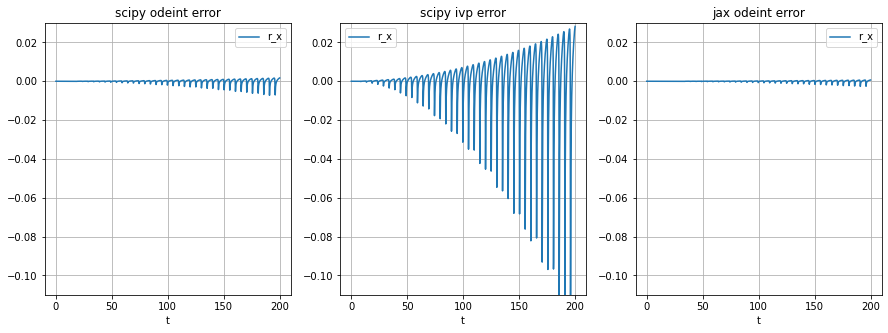

In [10]:
_ = plt.figure(figsize=(15,5)), plt.subplot(1,3,1)
_ = plt.plot(tsteps, scipy_result_faster[:, 0]-jax_result[:, 0], label='r_x')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.ylim(-0.11,0.03), plt.title('scipy odeint error')
_ = plt.subplot(1,3,2), plt.plot(tsteps, scipy_ivp_faster[:, 0]-jax_result[:, 0], label='r_x')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.ylim(-0.11,0.03), plt.title('scipy ivp error')
_ = plt.subplot(1,3,3), plt.plot(tsteps, jax_result_faster[:, 0]-jax_result[:, 0], label='r_x')
_ = plt.legend(loc='best'), plt.xlabel('t'), plt.grid()
_ = plt.ylim(-0.11,0.03), plt.title('jax odeint error')

In [11]:
print('Timing scipy odeint')
%timeit osp_integrate.odeint(relative_dynamics, y0, tsteps, (Gm_val,), rtol=1e-11)

Timing scipy odeint
1 loop, best of 3: 1.73 s per loop


In [12]:
print('Timing scipy ivp')
%timeit osp_integrate.solve_ivp(relative_dynamics_flipped_inputs, np.array([tsteps[0],tsteps[-1]]), y0, t_eval=tsteps, args=(Gm_val,), rtol=1e-11).y

Timing scipy ivp
1 loop, best of 3: 2.12 s per loop


In [13]:
print('Timing jax')
%timeit odeint(relative_dynamics, y0, tsteps, np.array([Gm_val]), rtol=1e-11)

Timing jax
100 loops, best of 3: 3.02 ms per loop
